<a href="https://www.kaggle.com/code/c14210099/ctr-prediction?scriptVersionId=180435331" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/avazu-ctr-prediction/sampleSubmission.gz
/kaggle/input/avazu-ctr-prediction/train.gz
/kaggle/input/avazu-ctr-prediction/test.gz


## Import Pyspark

In [4]:
!pip install -q pyspark

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('Avazu CTR').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/29 15:24:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Import Library

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RobustScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Load the Training Data

total rows : 40428967

In [7]:
total_data = 40428967

# load 10% data
train_df = spark.read.csv('/kaggle/input/avazu-ctr-prediction/train.gz', header=True, inferSchema=True).limit(int(total_data * 0.1))

In [8]:
train_df.printSchema()

root
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)



In [9]:
# show how many data
train_df.count()

4042896

In [22]:
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import to_timestamp, col, hour

In [15]:
train_df = train_df.withColumn('datetime', to_timestamp(col('hour').cast(StringType()), format="yyMMddHH").cast("timestamp"))
train_df = train_df.withColumn('hour', hour(col('datetime')))

In [16]:
train_df.printSchema()

root
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)
 |-- datetime: timestamp (nullable = true)


### Exploratory Data Analysis

In [13]:
# eda
train_df.describe().toPandas()

24/05/29 12:29:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,count,4042896,4042896,4042896,4042896,4042896,4042896,4042896,4042896,4042896,...,4042896,4042896,4042896,4042896,4042896,4042896,4042896,4042896,4042896,4042896
1,mean,9221237852815831434.0562,0.17393769218896554,1.4102109903193898E7,1005.0033688722144,0.2594526299959237,Infinity,Infinity,Infinity,Infinity,...,1.0241965165564486,0.21866627288953266,18392.58820607802,319.1193817501118,58.39506482481865,2064.186714177164,1.6255305602716468,199.50903065525307,49153.223452198625,76.4742714133631
2,stddev,5.3291799094352118E18,0.3790559417350842,6.019660099449138,1.0857589944408435,0.46936969714217397,NaN,NaN,NaN,NaN,...,0.5194055962434381,0.6828337769384187,4576.552195082104,23.724772818190708,44.20469836882396,560.0584922702172,1.3522951034857,320.0841294348049,50047.34766029132,60.23668487531359
3,min,2052565170180,0,14102100,1001,0,00255fb4,005b495a,0569f928,000d6291,...,0,0,375,120,20,112,0,33,-1,13
4,max,18446728150443224836,1,14102122,1012,7,fffe8e1c,fff602a2,f66779e6,fff4213a,...,5,5,21795,1024,1024,2513,3,1835,100248,221


In [14]:
# number of click
print(f'Number of click: {train_df[train_df["click"] == 1].count()}')

# number of non-click
print(f'Number of non-click: {train_df[train_df["click"] == 0].count()}')

Number of click: 703212


Number of non-click: 3339684


In [31]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
(
    train_df.select('hour', 'click')
    .crosstab('hour', 'click')
    .withColumn('hour_click', col('hour_click').cast(IntegerType()))
    .sort('hour_click')
    .withColumn('click_rate', col('1') / (col('0') + col('1')))
    .show() 
)

+----------+------+-----+-------------------+
|hour_click|     0|    1|         click_rate|
+----------+------+-----+-------------------+
|         0| 98214|20792|0.17471387997243837|
|         1|113569|23873|0.17369508592715474|
|         2|176206|31265|0.15069575988933392|
|         3|160525|32830| 0.1697913164903933|
|         4|224685|40026| 0.1512064100094065|
|         5|232791|40709|0.14884460694698354|
|         6|201063|38657|0.16125896879692975|
|         7|173780|35531| 0.1697521869371414|
|         8|172024|35220|0.16994460635772327|
|         9|193115|37802|0.16370384164006982|
|        10|164334|35694|0.17844501769752236|
|        11|140190|35476|0.20195143055571368|
|        12|114845|28775|0.20035510374599638|
|        13|155056|35425|0.18597655409200917|
|        14|139363|35168|0.20150002005374404|
|        15|142076|34080| 0.1934648833988056|
|        16|138400|33469|0.19473552531288366|
|        17|139376|32557|0.18935864551889398|
|        18|124895|27470| 0.180290

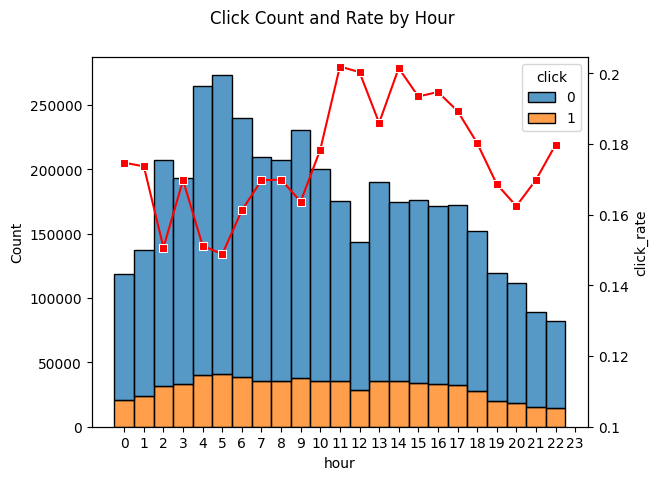

In [33]:
ax = sns.histplot(x='hour', hue='click', data=train_df.select('hour', 'click').toPandas(), multiple='stack', discrete=True)
ax.set_xticks(list(range(24)), list(range(24)))

ax2 = ax.twinx()
click_rate = (
    train_df.select('hour', 'click')
    .crosstab('hour', 'click')
    .withColumn('hour_click', col('hour_click').cast(IntegerType()))
    .sort('hour_click')
    .withColumn('click_rate', col('1') / (col('0') + col('1')))
)
sns.lineplot(x='hour_click', y='click_rate',data=click_rate.toPandas(),marker='s',color='red',ax=ax2)
ax2.set_yticks([x/100 for x in range(10, 22, 2)], [x/100 for x in range(10, 22, 2)])

plt.suptitle('Click Count and Rate by Hour')

plt.show()

In [29]:
(
    train_df.select('click', 'banner_pos')
    .crosstab('banner_pos', 'click')
    .sort('banner_pos_click')
    .withColumn('click_rate', col('1') / (col('0') + col('1')))
    .show()
)

+----------------+-------+------+-------------------+
|banner_pos_click|      0|     1|         click_rate|
+----------------+-------+------+-------------------+
|               0|2513377|501427|0.16632159171873195|
|               1| 821739|200668|0.19627017420655374|
|               2|   1147|   147|0.11360123647604328|
|               3|     17|     0|                0.0|
|               4|    413|    73|0.15020576131687244|
|               5|   2398|   235|0.08925180402582605|
|               7|    593|   662| 0.5274900398406375|
+----------------+-------+------+-------------------+



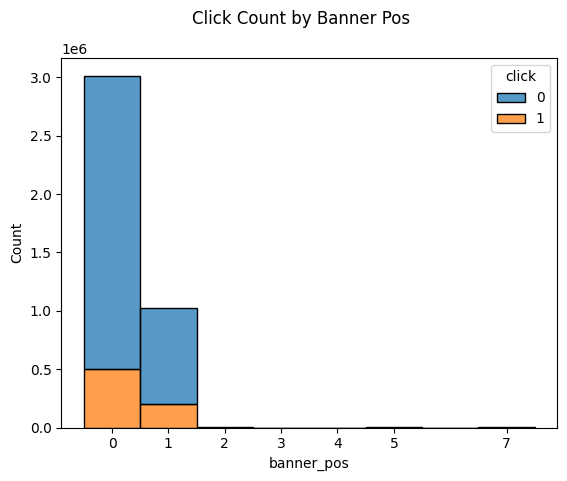

In [32]:
ax = sns.histplot(x='banner_pos', hue='click', data=train_df.select('banner_pos', 'click').toPandas(), multiple='stack', discrete=True)
distinct_values = train_df.select('banner_pos').distinct().sort('banner_pos').rdd.flatMap(lambda x: x).collect()
ax.set_xticks(distinct_values, distinct_values)

plt.suptitle('Click Count by Banner Pos')

plt.show()

In [15]:
# group by site id
train_df.groupBy('site_id').count().orderBy('count', ascending=False).toPandas()

,site_id,count
0,85f751fd,1494649
1,1fbe01fe,755928
2,e151e245,205147
3,d9750ee7,147992
4,5b08c53b,78202
...,...,...
2855,4e16b6bf,1
2856,1418cff1,1
2857,6ac91893,1
2858,8d9e19c8,1


In [16]:
# group by site domain
train_df.groupBy('site_domain').count().orderBy('count', ascending=False).toPandas()

,site_domain,count
0,c4e18dd6,1553191
1,f3845767,755928
2,7e091613,215570
3,98572c79,155557
4,7687a86e,108132
...,...,...
3367,47a82cf2,1
3368,c2adadc7,1
3369,a60714ed,1
3370,324dcd3c,1


In [17]:
# group by site category
train_df.groupBy('site_category').count().orderBy('count', ascending=False).toPandas()

,site_category,count
0,50e219e0,1638075
1,f028772b,1133682
2,28905ebd,883066
3,3e814130,278064
4,f66779e6,37697
5,335d28a8,18695
6,75fa27f6,12991
7,76b2941d,12957
8,0569f928,8069
9,72722551,7898


In [18]:
# group by app id
train_df.groupBy('app_id').count().orderBy('count', ascending=False).toPandas()

,app_id,count
0,ecad2386,2548247
1,e2fcccd2,143583
2,7358e05e,76660
3,febd1138,73230
4,9c13b419,68345
...,...,...
4125,eb2d374c,1
4126,bfa2d110,1
4127,1929ea63,1
4128,95720db1,1


In [19]:
# group by app domain
train_df.groupBy('app_domain').count().orderBy('count', ascending=False).toPandas()

,app_domain,count
0,7801e8d9,2720143
1,2347f47a,581375
2,5c5a694b,143603
3,d9b5648e,130607
4,b9528b13,79157
...,...,...
278,5048f612,1
279,3419dd80,1
280,c0e0e9ca,1
281,6437e20c,1


In [20]:
# check missing value
from pyspark.sql.functions import isnan, when, count, col
print(f'Number of missing value: {train_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_df.columns]).collect()[0].asDict()}')

Number of missing value: {'id': 0, 'click': 0, 'hour': 0, 'C1': 0, 'banner_pos': 0, 'site_id': 0, 'site_domain': 0, 'site_category': 0, 'app_id': 0, 'app_domain': 0, 'app_category': 0, 'device_id': 0, 'device_ip': 0, 'device_model': 0, 'device_type': 0, 'device_conn_type': 0, 'C14': 0, 'C15': 0, 'C16': 0, 'C17': 0, 'C18': 0, 'C19': 0, 'C20': 0, 'C21': 0}


## Data Preprocessing

In [21]:
# print numerical and categorical columns
numerical_columns = [train_df.dtypes[i] for i in range(len(train_df.dtypes)) if train_df.dtypes[i][1] == 'int' or train_df.dtypes[i][1] == 'double']
categorical_columns = [train_df.dtypes[i] for i in range(len(train_df.dtypes)) if train_df.dtypes[i][1] == 'string']

In [22]:
numerical_columns

[('click', 'int'),
 ('hour', 'int'),
 ('C1', 'int'),
 ('banner_pos', 'int'),
 ('device_type', 'int'),
 ('device_conn_type', 'int'),
 ('C14', 'int'),
 ('C15', 'int'),
 ('C16', 'int'),
 ('C17', 'int'),
 ('C18', 'int'),
 ('C19', 'int'),
 ('C20', 'int'),
 ('C21', 'int')]

In [23]:
categorical_columns

[('site_id', 'string'),
 ('site_domain', 'string'),
 ('site_category', 'string'),
 ('app_id', 'string'),
 ('app_domain', 'string'),
 ('app_category', 'string'),
 ('device_id', 'string'),
 ('device_ip', 'string'),
 ('device_model', 'string')]

### Label Encoding

In [24]:
click_count = train_df[train_df["click"] == 1].count()
no_click_count = train_df[train_df["click"] == 0].count()

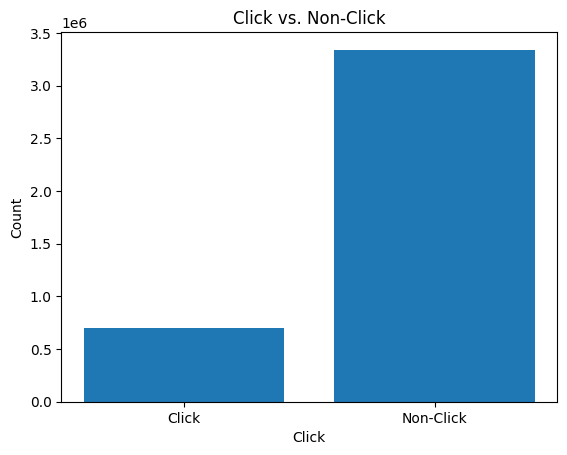

In [25]:
plt.title('Click vs. Non-Click')
plt.bar(['Click', 'Non-Click'], [click_count, no_click_count])
plt.ylabel('Count')
plt.xlabel('Click')
plt.show()

In [26]:
def undersample_data (df, click_count, no_click_count) : 
    fractions = click_count/no_click_count
    undersampled_df = df.sampleBy('click', fractions={0: fractions, 1: 1}, seed=11)
    
    return undersampled_df

In [27]:
preprocessed_df = undersample_data(train_df, click_count, no_click_count)
print(f'Number of click: {preprocessed_df[preprocessed_df["click"] == 1].count()}')
print(f'Number of non-click: {preprocessed_df[preprocessed_df["click"] == 0].count()}')

Number of click: 703212


Number of non-click: 702005


### Categorical Label Encoding

In [28]:
def labelEncoding (df) :
    categorical_columns = [df.dtypes[i] for i in range(len(df.dtypes)) if df.dtypes[i][1] == 'string']

    for col in categorical_columns:
        string_indexer = StringIndexer(inputCol=col[0], outputCol=col[0]+'_index')
        df = string_indexer.fit(df).transform(df)
        df = df.drop(col[0])

    return df

In [29]:
preprocessed_df = labelEncoding(preprocessed_df)

In [30]:
# show 10 rows of preprocessed df
preprocessed_df.limit(10).toPandas()

24/05/29 12:42:23 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,...,C21,site_id_index,site_domain_index,site_category_index,app_id_index,app_domain_index,app_category_index,device_id_index,device_ip_index,device_model_index
0,1000009418151094273,0,14102100,1005,0,1,2,15706,320,50,...,79,1.0,1.0,2.0,0.0,0.0,0.0,0.0,8.0,212.0
1,10000169349117863715,0,14102100,1005,0,1,0,15704,320,50,...,79,1.0,1.0,2.0,0.0,0.0,0.0,0.0,32073.0,10.0
2,10000949271186029916,1,14102100,1005,0,1,2,15707,320,50,...,79,1.0,1.0,2.0,0.0,0.0,0.0,0.0,270137.0,25.0
3,10001868339616595934,0,14102100,1005,1,1,0,17747,320,50,...,33,2.0,2.0,1.0,0.0,0.0,0.0,0.0,131745.0,160.0
4,10003539039235338011,0,14102100,1005,0,1,0,15699,320,50,...,79,1.0,1.0,2.0,0.0,0.0,0.0,0.0,156907.0,0.0
5,10004482643316086592,0,14102100,1005,0,1,0,21234,320,50,...,61,0.0,0.0,0.0,387.0,3.0,2.0,0.0,551897.0,49.0
6,10004765361151096125,1,14102100,1005,0,1,0,15701,320,50,...,79,1.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,85.0
7,10005249248600843539,0,14102100,1005,0,1,0,15706,320,50,...,79,1.0,1.0,2.0,0.0,0.0,0.0,0.0,4731.0,63.0
8,10005334911727438633,0,14102100,1010,1,4,0,21665,320,50,...,117,0.0,0.0,0.0,17.0,0.0,1.0,1131.0,78414.0,236.0
9,10005541670676403131,0,14102100,1005,1,1,0,20984,320,50,...,46,2.0,2.0,1.0,0.0,0.0,0.0,0.0,168736.0,306.0


### Get Correlation Matrix

In [31]:
def get_corr (df) :
    vector_col = 'corr_features'
    assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)

    matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
    matrix = np.array(matrix.toArray())
    return matrix

In [32]:
corr = get_corr(preprocessed_df)

24/05/29 12:43:06 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB
24/05/29 12:43:08 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB
24/05/29 12:43:23 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB
24/05/29 12:43:24 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB
24/05/29 12:43:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


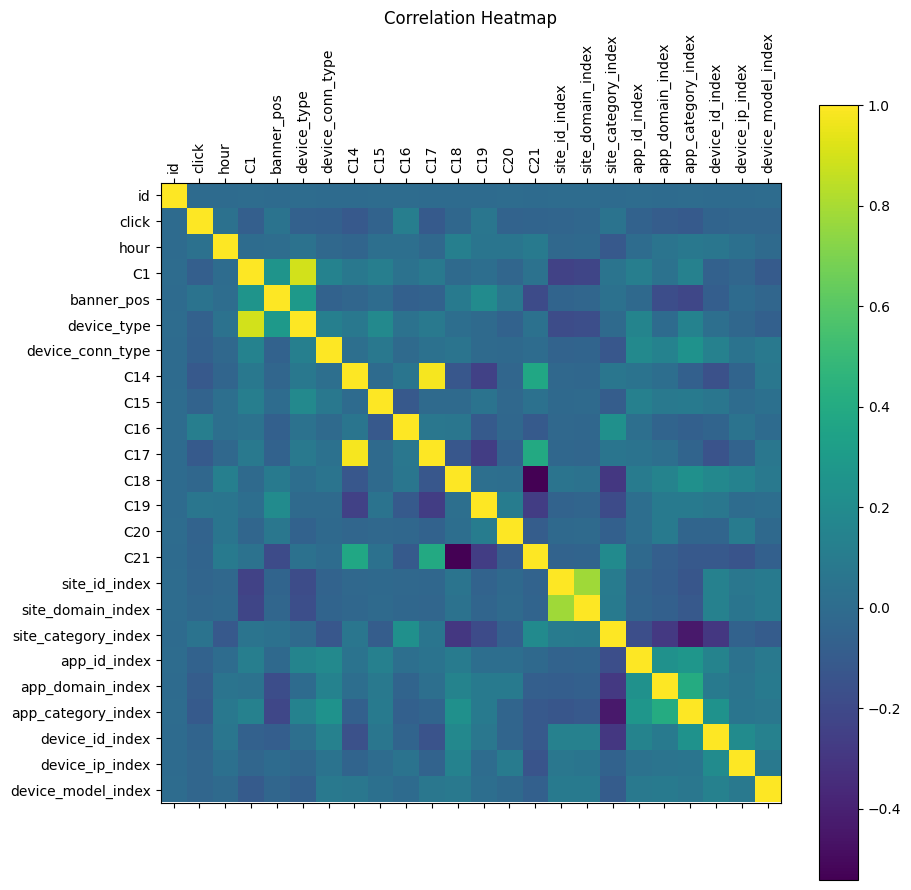

In [33]:
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)
plt.title('Correlation Heatmap')
plt.xticks(range(len(preprocessed_df.columns)), preprocessed_df.columns, rotation='vertical')
plt.yticks(range(len(preprocessed_df.columns)), preprocessed_df.columns)
plt.colorbar()
plt.show()

### Drop unnecessary columns

In [34]:
def drop_columns (df, collumns_to_drop) :
    for col in collumns_to_drop :
        df = df.drop(col)
    return df

In [35]:
collumns_to_drop = ['id', 'datetime']
preprocessed_df = drop_columns(preprocessed_df, collumns_to_drop)

In [36]:
preprocessed_df.printSchema()

root
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)
 |-- site_id_index: double (nullable = false)
 |-- site_domain_index: double (nullable = false)
 |-- site_category_index: double (nullable = false)
 |-- app_id_index: double (nullable = false)
 |-- app_domain_index: double (nullable = false)
 |-- app_category_index: double (nullable = false)
 |-- device_id_index: double (nullable = false)
 |-- device_ip_index: double (nullable = false)
 |-- device_model_index: double (nullable = false)



### Features Columns

In [37]:
def add_features_column (df) :
    columns = []
    
    for each in df.columns :
        if each != 'click' :
            columns.append(each)
            
    assembler = VectorAssembler(inputCols=columns, outputCol='features')
    df = assembler.transform(df)
    df = df.drop(*columns)
            
    return df

In [38]:
preprocessed_df = add_features_column(preprocessed_df)

In [39]:
preprocessed_df.limit(5).toPandas()

24/05/29 12:44:10 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


,click,features
0,0,"[14102100.0, 1005.0, 0.0, 1.0, 2.0, 15706.0, 3..."
1,0,"[14102100.0, 1005.0, 0.0, 1.0, 0.0, 15704.0, 3..."
2,1,"[14102100.0, 1005.0, 0.0, 1.0, 2.0, 15707.0, 3..."
3,0,"[14102100.0, 1005.0, 1.0, 1.0, 0.0, 17747.0, 3..."
4,0,"[14102100.0, 1005.0, 0.0, 1.0, 0.0, 15699.0, 3..."


### Normalize Features

In [40]:
def normalize_features (df) :
    scaler = RobustScaler(inputCol='features', outputCol='scaled_features')
    df = scaler.fit(df).transform(df)
    df = df.drop('features')
    df = df.withColumnRenamed('scaled_features', 'features')
    return df

In [41]:
preprocessed_df = normalize_features(preprocessed_df)

24/05/29 12:44:43 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


In [42]:
preprocessed_df.limit(5).toPandas()

24/05/29 12:45:33 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


,click,features
0,0,"[1410210.0, 0.0, 0.0, 0.0, 0.0, 3.113181367690..."
1,0,"[1410210.0, 0.0, 0.0, 0.0, 0.0, 3.112784935579..."
2,1,"[1410210.0, 0.0, 0.0, 0.0, 0.0, 3.113379583746..."
3,0,"[1410210.0, 0.0, 1.0, 0.0, 0.0, 3.517740336967..."
4,0,"[1410210.0, 0.0, 0.0, 0.0, 0.0, 3.111793855302..."


## Data Training

### Split Data

In [43]:
train_df, test_df = preprocessed_df.randomSplit([0.8, 0.2], seed=11)

In [44]:
print(f'Number of train data: {train_df.count()}')
print(f'Number of test data: {test_df.count()}')

24/05/29 12:46:05 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


Number of train data: 1123864


24/05/29 12:46:53 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


Number of test data: 281353


### Model Building

In [45]:
model = DecisionTreeClassifier(labelCol='click', featuresCol='features')
model = model.fit(train_df)
result = model.transform(test_df)

24/05/29 12:48:08 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:48:56 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:49:13 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:49:32 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:49:51 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:50:11 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:50:13 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:50:17 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:50:19 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


### Model Evaluation

In [46]:
evaluator = MulticlassClassificationEvaluator(labelCol='click', metricName='accuracy')
accuracy = evaluator.evaluate(result)
precision = evaluator.evaluate(result, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(result, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(result, {evaluator.metricName: "f1"})

24/05/29 12:50:55 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:51:43 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:52:31 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
24/05/29 12:53:17 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


In [47]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Accuracy: 0.6471016836500766
Precision: 0.6504425344797564
Recall: 0.6471016836500766
F1: 0.6450969564165558
